<a href="https://colab.research.google.com/github/rjpost20/Anomalous-Bank-Transactions-Detection-Project/blob/main/Notebook-1_Intro-PrelimEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/rjpost20/Anomalous-Bank-Transactions-Detection-Project/blob/main/data/AdobeStock_319163865.jpeg?raw=true">
Image by <a href="https://stock.adobe.com/contributor/200768506/andsus?load_type=author&prev_url=detail" >AndSus</a> on Adobe Stock

# Phase 5 Project: *Detecting Anomalous Financial Transactions*

## Notebook 1: Intro, EDA and Preprocessing

### By Ryan Posternak

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 25th, 2022<br>
Instructor: Joseph Mata

## Goal: Build a model for FinCEN that can accurately identify anomalous financial transactions, as measured by positive class F1 score on testing data

*This is a project for learning purposes. FinCEN is not involved with this project in any way, nor is any other governmental institution or organization.*

<br>

# Overview and Business Understanding

Money laundering is a <a href="https://www.fincen.gov/what-money-laundering" > major global concern</a> for national governments and financial institutions. It represents a threat not only for the agencies charged with policing such activity, but also the industry participants themselves, who face reputational damage, fines and increased regulatory scrutiny should it be revealed that bad actors used their networks for illicit financial activity. The UN Office on Drugs and Crime <a href="https://www.unodc.org/unodc/en/money-laundering/overview.html" > estimates </a> that money laundering encompasses 2 - 5% of global GDP, representing \$800 billion - \$2 trillion in 2022 USD. The specific motivations for money laundering are numerous, but can include terrorist financing, proliferation financing, and attempted concealment of funds obtained from theft and major crimes.

One promising tool in the fight against money laundering is the use of machine learning models to detect anomalous financial transactions. When such models flag a transaction, further investigation can be conducted to determine if the activity indeed represents illegal criminal activity or not. The accuracy of such models, however, is paramount, as the limited resources of banks and regulatory agencies could not possibly hope to investigate more than a handful of the <a href="https://www.federalreserve.gov/paymentsystems/fedach_yearlycomm.htm" > tens of millions</a> of transactions that occur daily.

The goal and motivation of this project is to provide the <a href="https://www.fincen.gov/" > Financial Crimes Enforcement Network</a>, aka FinCEN (*project is for academic purposes - FinCEN not actually involved*) with a machine learning model that can process routine financial transaction data and classify whether the transaction is anomalous or not. Such a model can be used not only by FinCEN and other regulatory agencies, but also by industry participants (i.e. financial institutions) to proactively detect and deter illicit activity being conducted through their systems.

Models are scored and ranked on their positive class (anomalous transactions, label `1`) F1 scores. The reasoning for this is two-fold: for one, this dataset is extremely imbalanced; anomalous transactions account for only ~0.1% of the training dataset. Given this, any metric that takes true negatives into account (accuracy, specificity, negative predictive value, AUC, etc.) would be heavily influenced by a high number of true negative predictions.

However, and this leads us to the second rationale, a high true negative rate is not valuable if it doesn't come with a high true positive rate as well. A model may be able to classify 99.99% of non-anomalous transactions, but if it only catches 1% of anomalous transactions, it is not ultimately of great value. On the other hand, a model may detect a significant percentage of anomalous transactions, but if it also flags even a minor percentage of the overall pool of non-anomalous transactions, human investigators will be faced with finding needles in a haystack, given how many more non-anomalous transactions there are in general. F1 scores rely on precision (percent of *predicted* positive results that are correct) and recall (percent of *actual* positive results that are correct), penalizing low scores in either one. Using F1 scores as a ranking metric, we can be sure that we are prioritizing models that fit the dynamics of their true use case.

<br>

# Data Understanding

Data for this project was obtained from <a href="https://www.drivendata.org/" >drivendata.org </a> as part of their PETs prize challenge: financial crime track. PETs, or privacy-enhancing technologies, involves finding new and innovative ways to harness the power of data while adhering to proper respect and safeguards for privacy, security and confidentiality of the data and its sources.

The data itself was produced through a collaboration between the National Institute of Standards and Technology (NIST) and the National Science Foundation (NSF). Due to the security and confidentiality concerns of such a sensitive matter, the dataset is synthetic, though it is intended to represent global payments data in broad strokes.

Three datasets were provided and used for this project: a transactions dataset for training totaling ~4.7M rows and 20 columns, a transactions dataset for testing totaling ~700k rows, and a bank accounts dataset totaling ~530k rows and 6 columns. The bank accounts dataset contains bank account IDs, the primary key of the dataset, which matches up with bank account IDs in both the training and testing data. The transactions datasets contain a binary discrete numerical `Label` column, the target variable for the project, with a `0` representing a non-anomalous transaction and a `1` representing an anomalous transaction.

<br>

# Imports, Reading in Data, and Preliminary Exploratory Data Analysis

### Google colab compatibility downloads

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz 
!tar xf spark-3.3.0-bin-hadoop3.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
!pip install pyspark==3.3.0
!pip install -q findspark
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://securit

In [2]:
# Connect to Google drive
from google.colab import drive, files
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


### Import libraries, packages and modules

In [3]:
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from IPython.display import HTML, display
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
# Check Colab RAM info
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
# Set text to wrap in Google colab notebook
def set_css():
    display(HTML("""
    <style>
      pre {
          white-space: pre-wrap;
      }
    </style>
    """))
get_ipython().events.register('pre_run_cell', set_css)

In [6]:
# Initialize Spark Session
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config("spark.ui.port", "4050")\
        .config("spark.driver.memory", "15g")\
        .getOrCreate()

spark

### Description of Features

**Dataset 1 – Transactions:**

`MessageId` - Globally unique identifier within this dataset for individual transactions<br>
`UETR` - The Unique End-to-end Transaction Reference—a 36-character string enabling traceability of all individual transactions associated with a single end-to-end transaction<br>
`TransactionReference` - Unique identifier for an individual transaction<br>
`Timestamp` - Time at which the individual transaction was initiated<br>
`Sender` - Institution (bank) initiating/sending the individual transaction<br>
`Receiver` - Institution (bank) receiving the individual transaction<br>
`OrderingAccount` - Account identifier for the originating ordering entity (individual or organization) for end-to-end transaction<br>
`OrderingName` - Name for the originating ordering entity<br>
`OrderingStreet` - Street address for the originating ordering entity<br>
`OrderingCountryCityZip` - Remaining address details for the originating ordering entity<br>
`BeneficiaryAccount` - Account identifier for the final beneficiary entity (individual or organization) for end-to-end transaction<br>
`BeneficiaryName` - Name for the final beneficiary entity<br>
`BeneficiaryStreet` - Street address for the final beneficiary entity<br>
`BeneficiaryCountryCityZip` - Remaining address details for the final beneficiary entity<br>
`SettlementDate` - Date the individual transaction was settled<br>
`SettlementCurrency` - Currency used for transaction<br>
`SettlementAmount` - Value of the transaction net of fees/transfer charges/forex<br>
`InstructedCurrency` - Currency of the individual transaction as instructed to be paid by the Sender<br>
`InstructedAmount` - Value of the individual transaction as instructed to be paid by the Sender<br>
`Label` - Boolean indicator of whether the transaction is anomalous or not. This is the target variable for the prediction task.<br>
<br>
**Dataset 2 – Banks:**

`Bank` - Identifier for the bank<br>
`Account` - Identifier for the account<br>
`Name` - Name of the account<br>
`Street` - Street address associated with the account<br>
`CountryCityZip` - Remaining address details associated with the account<br>
`Flags` - Enumerated data type indicating potential issues or special features that have been associated with an account. Flag definitions are below:<br>
00 - No flags<br>
01 - Account closed<br>
03 - Account recently opened<br>
04 - Name mismatch<br>
05 - Account under monitoring<br>
06 - Account suspended<br>
07 - Account frozen<br>
08 - Non-transaction account<br>
09 - Beneficiary deceased<br>
10 - Invalid company ID<br>
11 - Invalid individual ID<br>
<br>
Additional information from data providers:<br>
"Because each end-to-end transaction is defined by one originating orderer and one final beneficiary, the `OrderingAccount` and `BeneficiaryAccount` in a given row may not necessarily belong to the bank in that row's `Sender` and the bank in that row's `Receiver`, respectively. The correct way to associate an `OrderingAccount` to the correct bank is to identify the `Sender` bank in the originating (first) individual transaction in that end-to-end transaction, and the correct way to associate a `BeneficiaryAccount` to the correct bank is to identify the `Receiver` bank in the final (last) individual transaction in that end-to-end transaction."

## Read in Data

In [7]:
# Read in transactions training and testing data csv files as Spark DataFrames
train_df = spark.read.csv(drive_path + 'transaction_train_dataset.csv', header=True, inferSchema=True)
test_df = spark.read.csv(drive_path + 'transaction_test_dataset.csv', header=True, inferSchema=True)

# Read in banks data csv file to a Spark DataFrame
banks_df = spark.read.csv(drive_path + 'bank_dataset.csv', header=True, inferSchema=True)

<br>

## Preliminary EDA

In [10]:
# Print shape of dataframes
print(f"train_df:  {train_df.count():,} Rows, {len(train_df.columns)} Columns")
print(f"test_df:  {test_df.count():,} Rows, {len(test_df.columns)} Columns")
print(f"banks_df:  {banks_df.count():,} Rows, {len(banks_df.columns)} Columns")

train_df:  4,691,725 Rows, 20 Columns
test_df:  705,108 Rows, 20 Columns
banks_df:  527,503 Rows, 6 Columns


In [10]:
# Print schema of train_df dataframe
train_df.printSchema()

root
 |-- MessageId: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- UETR: string (nullable = true)
 |-- Sender: string (nullable = true)
 |-- Receiver: string (nullable = true)
 |-- TransactionReference: string (nullable = true)
 |-- OrderingAccount: string (nullable = true)
 |-- OrderingName: string (nullable = true)
 |-- OrderingStreet: string (nullable = true)
 |-- OrderingCountryCityZip: string (nullable = true)
 |-- BeneficiaryAccount: string (nullable = true)
 |-- BeneficiaryName: string (nullable = true)
 |-- BeneficiaryStreet: string (nullable = true)
 |-- BeneficiaryCountryCityZip: string (nullable = true)
 |-- SettlementDate: integer (nullable = true)
 |-- SettlementCurrency: string (nullable = true)
 |-- SettlementAmount: double (nullable = true)
 |-- InstructedCurrency: string (nullable = true)
 |-- InstructedAmount: double (nullable = true)
 |-- Label: integer (nullable = true)



In [12]:
# Print schema of banks_df dataframe
banks_df.printSchema()

root
 |-- Bank: string (nullable = true)
 |-- Account: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- CountryCityZip: string (nullable = true)
 |-- Flags: integer (nullable = true)



In [13]:
# Display first row of train_df
train_df.show(n=1, truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------
 MessageId                 | TRA7CGN3FF                           
 Timestamp                 | 2022-01-01 00:00:00                  
 UETR                      | f474fdb3-4675-4fff-ab7e-3469f82bd6a7 
 Sender                    | DPSUFRPP                             
 Receiver                  | ABVVUS6S                             
 TransactionReference      | PETX22-FXIDA-7054                    
 OrderingAccount           | FR90714755422956984353               
 OrderingName              | PHACELIA HETEROPHYLLA                
 OrderingStreet            | 3| RUE HAMON                         
 OrderingCountryCityZip    | FR/42859 SAINTE AURÉLIE              
 BeneficiaryAccount        | 611024064274704358                   
 BeneficiaryName           | PAPAVER CALIFORNICUM                 
 BeneficiaryStreet         | 2584 CHARLES PLACE                   
 BeneficiaryCountryCityZip | US/ROJASLAND| DC 58442           

In [14]:
# Display first 5 rows of banks dataframe
banks_df.show(5, False)

+--------+------------------+-----------------------+-------------------------+--------------------------+-----+
|Bank    |Account           |Name                   |Street                   |CountryCityZip            |Flags|
+--------+------------------+-----------------------+-------------------------+--------------------------+-----+
|ABVVUS6S|611024064274690946|OXYTROPIS PODOCARPA    |784 YANG PASSAGE         |US/NEW SHANNON, IA 49432  |0    |
|ABVVUS6S|611024064274690947|VIOLA ◊ESCULENTA       |786 CINDY HARBOR         |US/APO AP 02202           |0    |
|ABVVUS6S|611024064274690948|CROSSOSOMA CALIFORNICUM|235 JAMES VIEWS SUITE 206|US/ORRVILLE, LA 49084     |0    |
|ABVVUS6S|611024064274690949|HYDROCOTYLE PROLIFERA  |270 THERESA MILL         |US/WEST JAYSHIRE, WA 67409|0    |
|ABVVUS6S|611024064274690950|CHAMAEMELUM FUSCATUM   |20734 ISAIAH BURG        |US/KINGVIEW, CO 71032     |0    |
+--------+------------------+-----------------------+-------------------------+-----------------

In [15]:
# Print number of unique values in each column of train_df; sample 1% of dataframe for efficiency
train_df_unique = train_df.sample(False, 0.01).agg(*(F.countDistinct(F.col(c)).alias(c) for c in train_df.columns))
total_rows = train_df_unique.collect()[0]['MessageId']

print(f"Number of unique values per column (in sample of 1% of dataframe):\n")
print(f"Total rows in sample: {total_rows}")
train_df_unique.show(truncate=False, vertical=True)

Number of unique values per column (in sample of 1% of dataframe):

Total rows in sample: 46885
-RECORD 0--------------------------
 MessageId                 | 46885 
 Timestamp                 | 19841 
 UETR                      | 46809 
 Sender                    | 15    
 Receiver                  | 16    
 TransactionReference      | 29144 
 OrderingAccount           | 41120 
 OrderingName              | 24118 
 OrderingStreet            | 39097 
 OrderingCountryCityZip    | 37007 
 BeneficiaryAccount        | 33848 
 BeneficiaryName           | 21589 
 BeneficiaryStreet         | 28304 
 BeneficiaryCountryCityZip | 28090 
 SettlementDate            | 23    
 SettlementCurrency        | 4     
 SettlementAmount          | 46884 
 InstructedCurrency        | 7     
 InstructedAmount          | 46809 
 Label                     | 2     



In [16]:
# Print number of unique values in each column of banks_df
banks_df_unique = banks_df.agg(*(F.countDistinct(F.col(c)).alias(c) for c in banks_df.columns))

print(f"Number of unique values per column:\n")
print(f"Total rows: {banks_df.count()}")
banks_df_unique.show(truncate=False, vertical=True)

Number of unique values per column:

Total rows: 527503
-RECORD 0----------------
 Bank           | 25     
 Account        | 527503 
 Name           | 34781  
 Street         | 427510 
 CountryCityZip | 391267 
 Flags          | 11     



In [17]:
# Print number of null/NaN values in each column of train_df
train_df_null = train_df.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c))\
                                 .alias(c) for c in train_df.columns if c != 'Timestamp'])

print('Number of null/NaN values per column:\n')
train_df_null.show(truncate=False, vertical=True)

Number of null/NaN values per column:

-RECORD 0------------------------
 MessageId                 | 0   
 UETR                      | 0   
 Sender                    | 0   
 Receiver                  | 0   
 TransactionReference      | 0   
 OrderingAccount           | 0   
 OrderingName              | 107 
 OrderingStreet            | 0   
 OrderingCountryCityZip    | 0   
 BeneficiaryAccount        | 0   
 BeneficiaryName           | 103 
 BeneficiaryStreet         | 0   
 BeneficiaryCountryCityZip | 0   
 SettlementDate            | 0   
 SettlementCurrency        | 0   
 SettlementAmount          | 0   
 InstructedCurrency        | 0   
 InstructedAmount          | 0   
 Label                     | 0   



In [18]:
# # Print number of null/NaN values in each column of banks_df
banks_df_null = banks_df.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c))\
                                 .alias(c) for c in banks_df.columns])

print('Number of null/NaN values per column:\n')
banks_df_null.show(truncate=False, vertical=True)

Number of null/NaN values per column:

-RECORD 0-------------
 Bank           | 0   
 Account        | 0   
 Name           | 20  
 Street         | 0   
 CountryCityZip | 0   
 Flags          | 0   



In [19]:
# Display summary statistics table of numeric columns in transactions dataframe
num_cols = [item[0] for item in train_df.dtypes if item[1] == 'int' or item[1] == 'double']

train_df.select(num_cols).summary().show(truncate=False)

+-------+------------------+---------------------+--------------------+---------------------+
|summary|SettlementDate    |SettlementAmount     |InstructedAmount    |Label                |
+-------+------------------+---------------------+--------------------+---------------------+
|count  |4691725           |4691725              |4691725             |4691725              |
|mean   |220111.88223073602|5.074057103357817E9  |9.416309758961706E9 |0.0010443919880214632|
|stddev |6.674532853334336 |2.7276372846653574E11|3.858897596339895E11|0.03230017733337347  |
|min    |220101            |0.67                 |0.67                |0                    |
|25%    |220106            |2237846.0            |2174568.32          |0                    |
|50%    |220112            |4623703.18           |4283045.1           |0                    |
|75%    |220118            |1.913998868E7        |1.981570822E7       |0                    |
|max    |220123            |5.6469401543203E13   |5.65016526

In [20]:
# Display value counts for 'Flags' feature of banks_df
flag_counts = banks_df.groupBy('Flags').count()

# Create list of accounts with non-zero flags in banks_df
non_zero_accounts = []
for row in banks_df.filter(banks_df.Flags != 0).collect()[:]:
    non_zero_accounts.append(row['Account'])

# Count occurences of ordering accounts associated with non-zero flags in training data
transactions_ordering_flagged_train = train_df.where(F.col('OrderingAccount').isin(non_zero_accounts)).count()
# Count occurences of beneficiary accounts associated with non-zero flags in training data
transactions_beneficiary_flagged_train = train_df.where(F.col('BeneficiaryAccount').isin(non_zero_accounts)).count()
# Count occurences of ordering accounts associated with non-zero flags in testing data
transactions_ordering_flagged_test = test_df.where(F.col('OrderingAccount').isin(non_zero_accounts)).count()
# Count occurences of beneficiary accounts associated with non-zero flags in testing data
transactions_beneficiary_flagged_test = test_df.where(F.col('BeneficiaryAccount').isin(non_zero_accounts)).count()

print(f"Accounts with non-zero flags: {len(non_zero_accounts)}\n")
print(f"Transactions with non-zero flag associated with OrderingAccount (train): {transactions_ordering_flagged_train}")
print(f"Transactions with non-zero flag associated with BeneficiaryAccount (train): {transactions_beneficiary_flagged_train}\n")
print(f"Transactions with non-zero flag associated with OrderingAccount (test): {transactions_ordering_flagged_test}")
print(f"Transactions with non-zero flag associated with BeneficiaryAccount (test): {transactions_beneficiary_flagged_test}\n")
print('Value counts of Flags feature of banks_df:\n')
flag_counts.show(truncate=False)

Accounts with non-zero flags: 578

Transactions with non-zero flag associated with OrderingAccount (train): 0
Transactions with non-zero flag associated with BeneficiaryAccount (train): 800

Transactions with non-zero flag associated with OrderingAccount (test): 0
Transactions with non-zero flag associated with BeneficiaryAccount (test): 107

Value counts of Flags feature of banks_df:

+-----+------+
|Flags|count |
+-----+------+
|0    |526925|
|1    |54    |
|6    |50    |
|3    |61    |
|5    |54    |
|9    |51    |
|4    |62    |
|8    |58    |
|7    |64    |
|10   |61    |
|11   |63    |
+-----+------+



In [24]:
# Display value counts for 'Label' column (classification target) in train_df
class_counts = train_df.groupBy('Label').count().withColumn('percent', F.col('count')/train_df.count())

class_counts.show(truncate=10)

+-----+-------+----------+
|Label|  count|   percent|
+-----+-------+----------+
|    1|   4900|0.00104...|
|    0|4686825|0.99895...|
+-----+-------+----------+



**Remarks:**
- This is an extremely imbalanced dataset - only about 0.1% of the data is in the positive class. We will need to address this class imbalance as part of the modeling process.

<br>

### Visualize target class distributions of sender and receiver banks used in transactions

In [23]:
# Sample 5% of train_df for visualizations (approximately 235k observations) for efficiency
viz_cols = ['Sender', 'Receiver', 'InstructedCurrency', 'SettlementCurrency', 'Label']
viz_df = train_df.select(viz_cols).sample(withReplacement=False, fraction=0.05, seed=42).toPandas()

In [25]:
# Display unique senders in training dataset
print(f"train_df, {train_df.select('Sender').distinct().count()} unique senders:")
train_df.select('Sender').distinct().show(5)

train_df, 16 unique senders:
+--------+
|  Sender|
+--------+
|ZOUOGB22|
|MRQHUS44|
|BRRGPTPL|
|GDYCCHZZ|
|HNYPITMM|
+--------+
only showing top 5 rows



In [26]:
# Display unique senders in training dataset where transaction is anomalous
unique_anom_senders_count = train_df.filter(train_df.Label == 1)\
                                    .select('Sender').distinct().count()

print(f"train_df, {unique_anom_senders_count} unique senders among anomalous transactions:")
train_df.filter(train_df.Label == 1).select('Sender').distinct().show(5)

train_df, 5 unique senders among anomalous transactions:
+--------+
|  Sender|
+--------+
|ZOUOGB22|
|WVOLDEMM|
|ABVVUS6S|
|DPSUFRPP|
|UNUSAL22|
+--------+



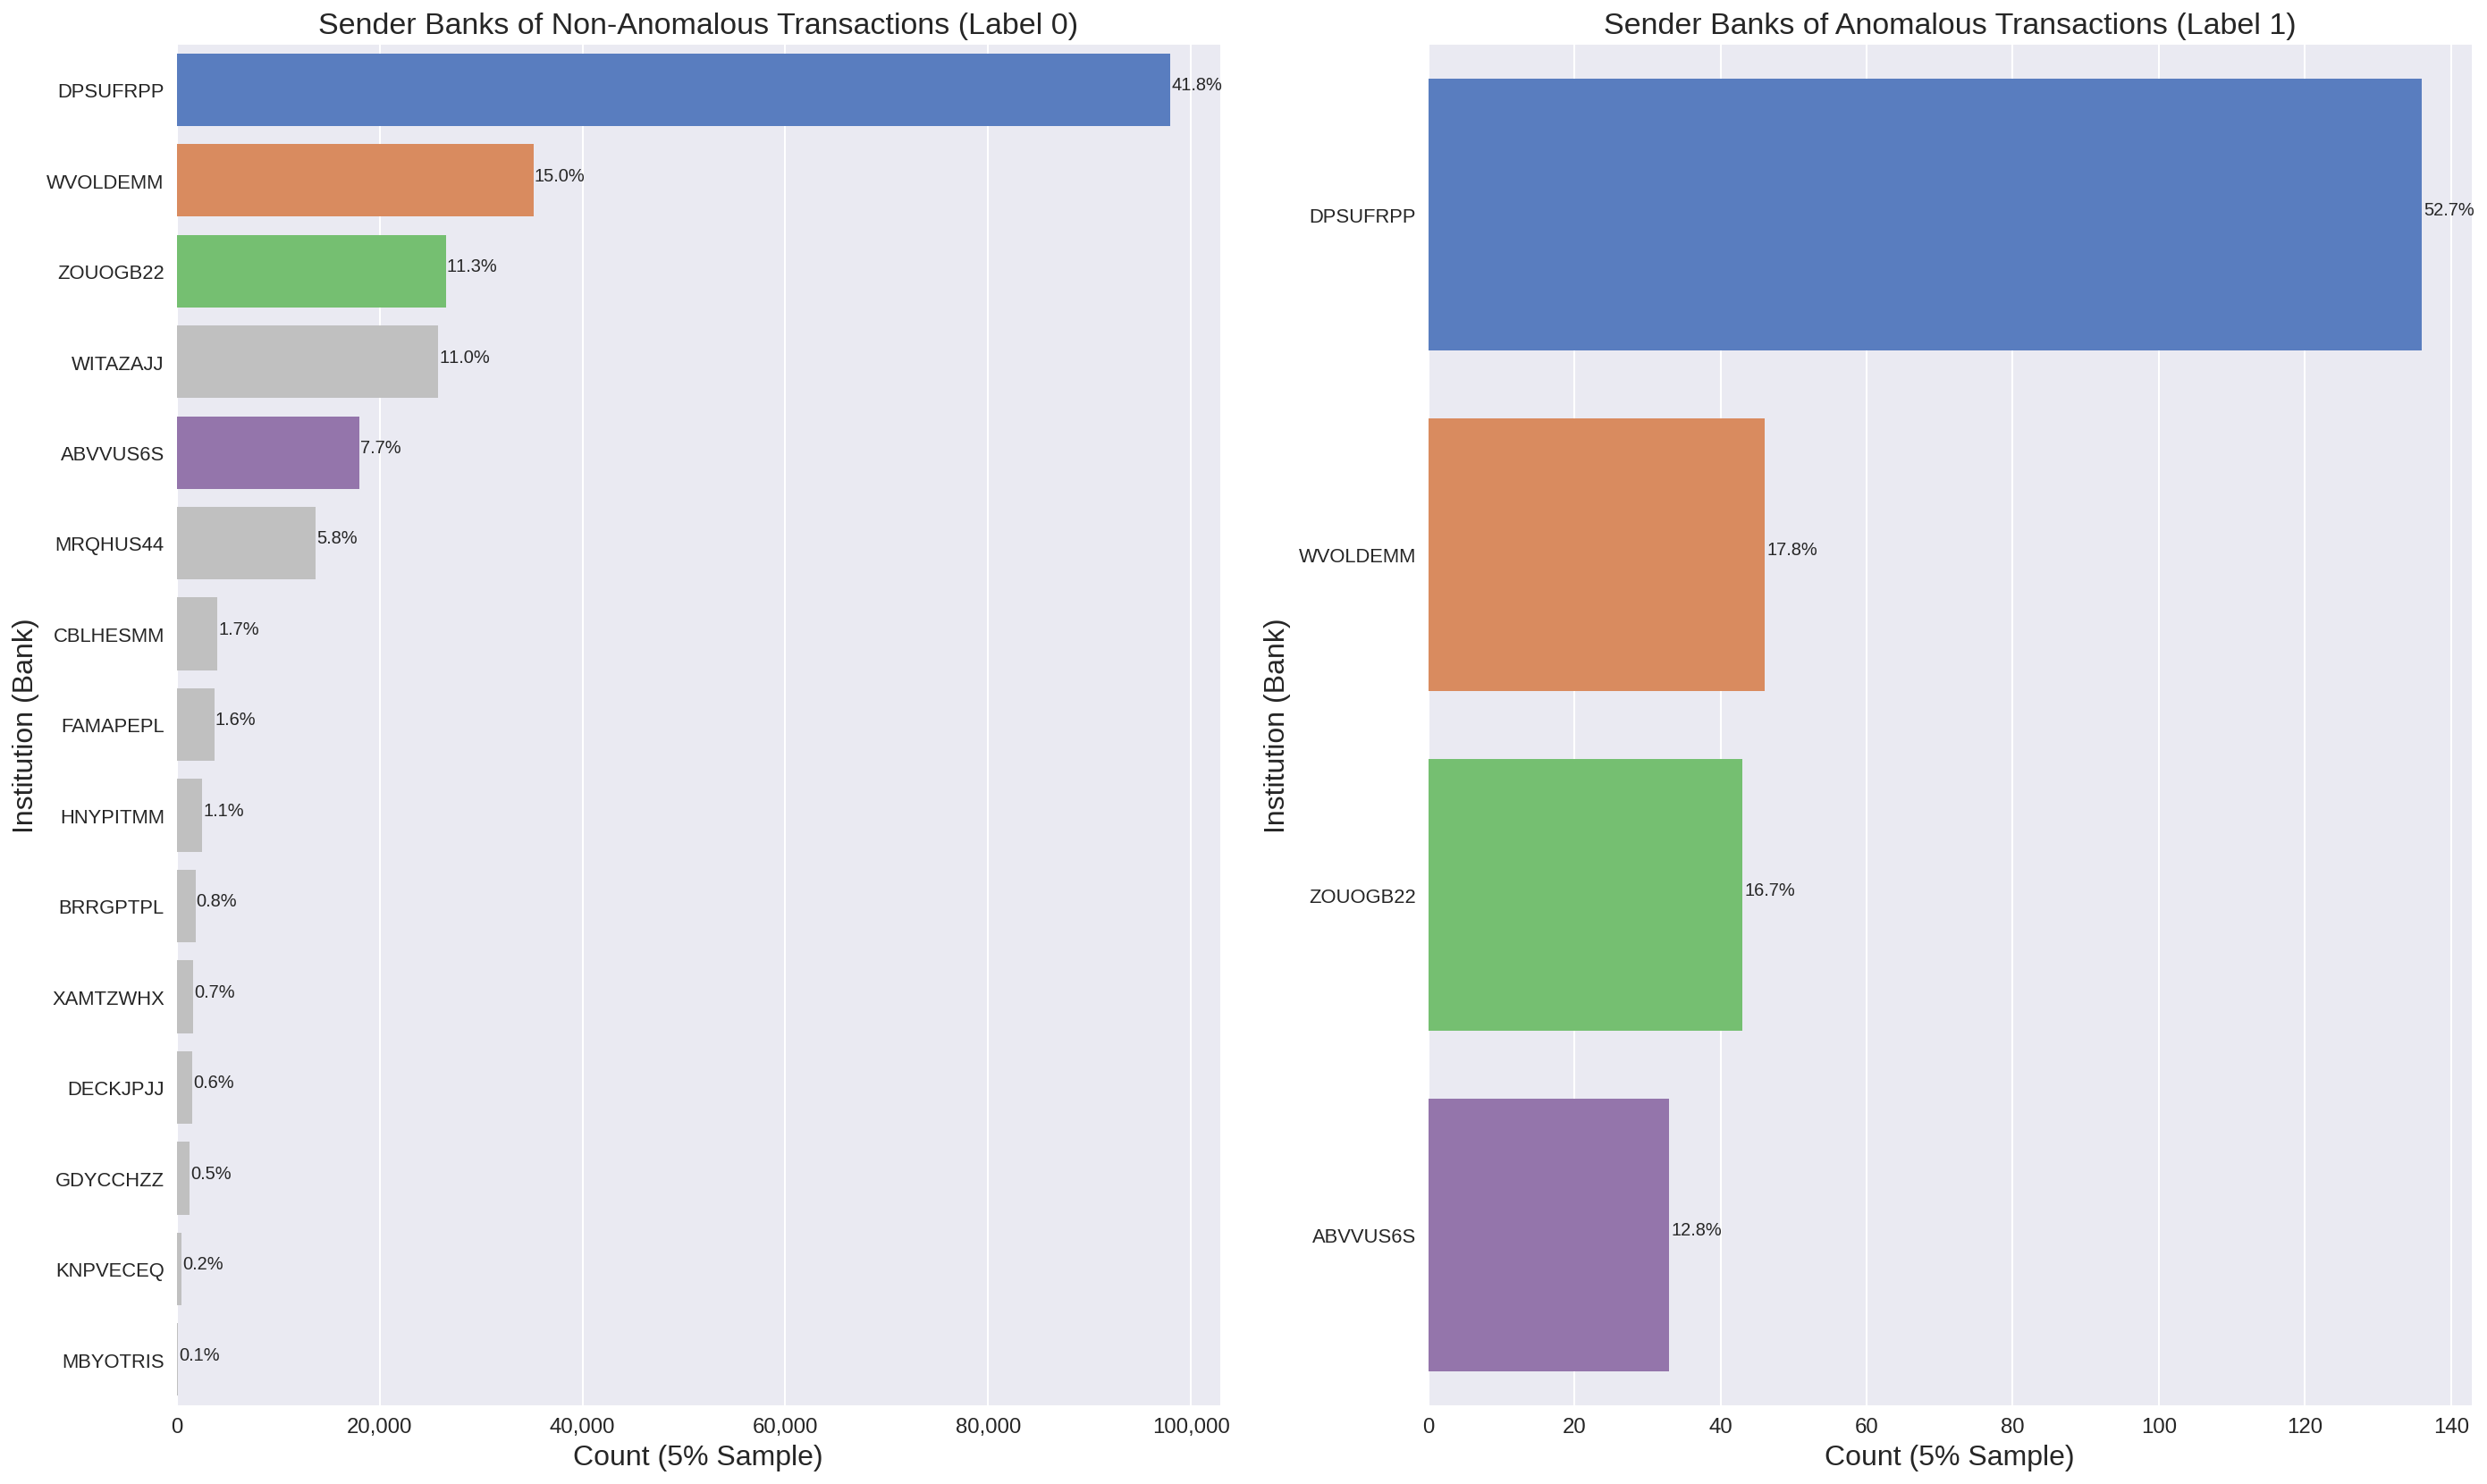

In [32]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(23, 14))

# Set consistent color palette where y-axis values in both axes, otherwise silver
palette = sns.color_palette('muted', as_cmap=True)*2
palette_map = {}
for val, color in zip(viz_df['Sender'].value_counts().index, palette):
    if val in viz_df[viz_df.Label == 0]['Sender'].value_counts().index \
    and val in viz_df[viz_df.Label == 1]['Sender'].value_counts().index:
        palette_map[val] = color
    else:
        palette_map[val]= 'silver'

# Plot countplot of non-anomalous transactions
sns.countplot(y='Sender', data=viz_df[viz_df.Label == 0], ax=ax1, palette=palette_map, 
              order=viz_df[viz_df.Label == 0]['Sender'].value_counts().index) # Order descending

# Plot countplot of anomalous transactions
sns.countplot(y='Sender', data=viz_df[viz_df.Label == 1], ax=ax2, palette=palette_map, 
              order=viz_df[viz_df.Label == 1]['Sender'].value_counts().index) # Order descending

# Print percentages to the right of bars (ax1)
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 0].shape[0])
    x = p.get_x() + p.get_width()+100
    y = p.get_y() + p.get_height()/2
    ax1.annotate(percentage, (x, y))

# Print percentages to the right of bars (ax2)
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 1].shape[0])
    x = p.get_x() + p.get_width()+0.3
    y = p.get_y() + p.get_height()/2
    ax2.annotate(percentage, (x, y))

ax1.set_title('Sender Banks of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Count (5% Sample)', fontsize=16)
ax1.set_xticklabels(['{:,}'.format(int(x)) for x in ax1.get_xticks()], fontsize=12)
ax1.set_ylabel('Institution (Bank)', fontsize=16)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=11)
ax2.set_title('Sender Banks of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Count (5% Sample)', fontsize=16)
ax2.set_xticklabels(ax2.get_xticks().astype(int), fontsize=12)
ax2.set_ylabel('Institution (Bank)', fontsize=16)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=11);

In [33]:
# Display unique receivers in training dataset
print(f"train_df, {train_df.select('Receiver').distinct().count()} unique receivers:")
train_df.select('Receiver').distinct().show(5)

train_df, 27 unique receivers:
+--------+
|Receiver|
+--------+
|WOEBDOSD|
|ZOUOGB22|
|BRRGPTPL|
|IHJTNL2A|
|GDYCCHZZ|
+--------+
only showing top 5 rows



In [34]:
# Display unique receivers in training dataset where transaction is anomalous
unique_anom_receivers_count = train_df.filter(train_df.Label == 1)\
                                      .select('Receiver').distinct().count()

print(f"train_df, {unique_anom_receivers_count} unique receivers among anomalous transactions:")
train_df.filter(train_df.Label == 1).select('Receiver').distinct().show(5)

train_df, 27 unique receivers among anomalous transactions:
+--------+
|Receiver|
+--------+
|WOEBDOSD|
|ZOUOGB22|
|BRRGPTPL|
|IHJTNL2A|
|GDYCCHZZ|
+--------+
only showing top 5 rows



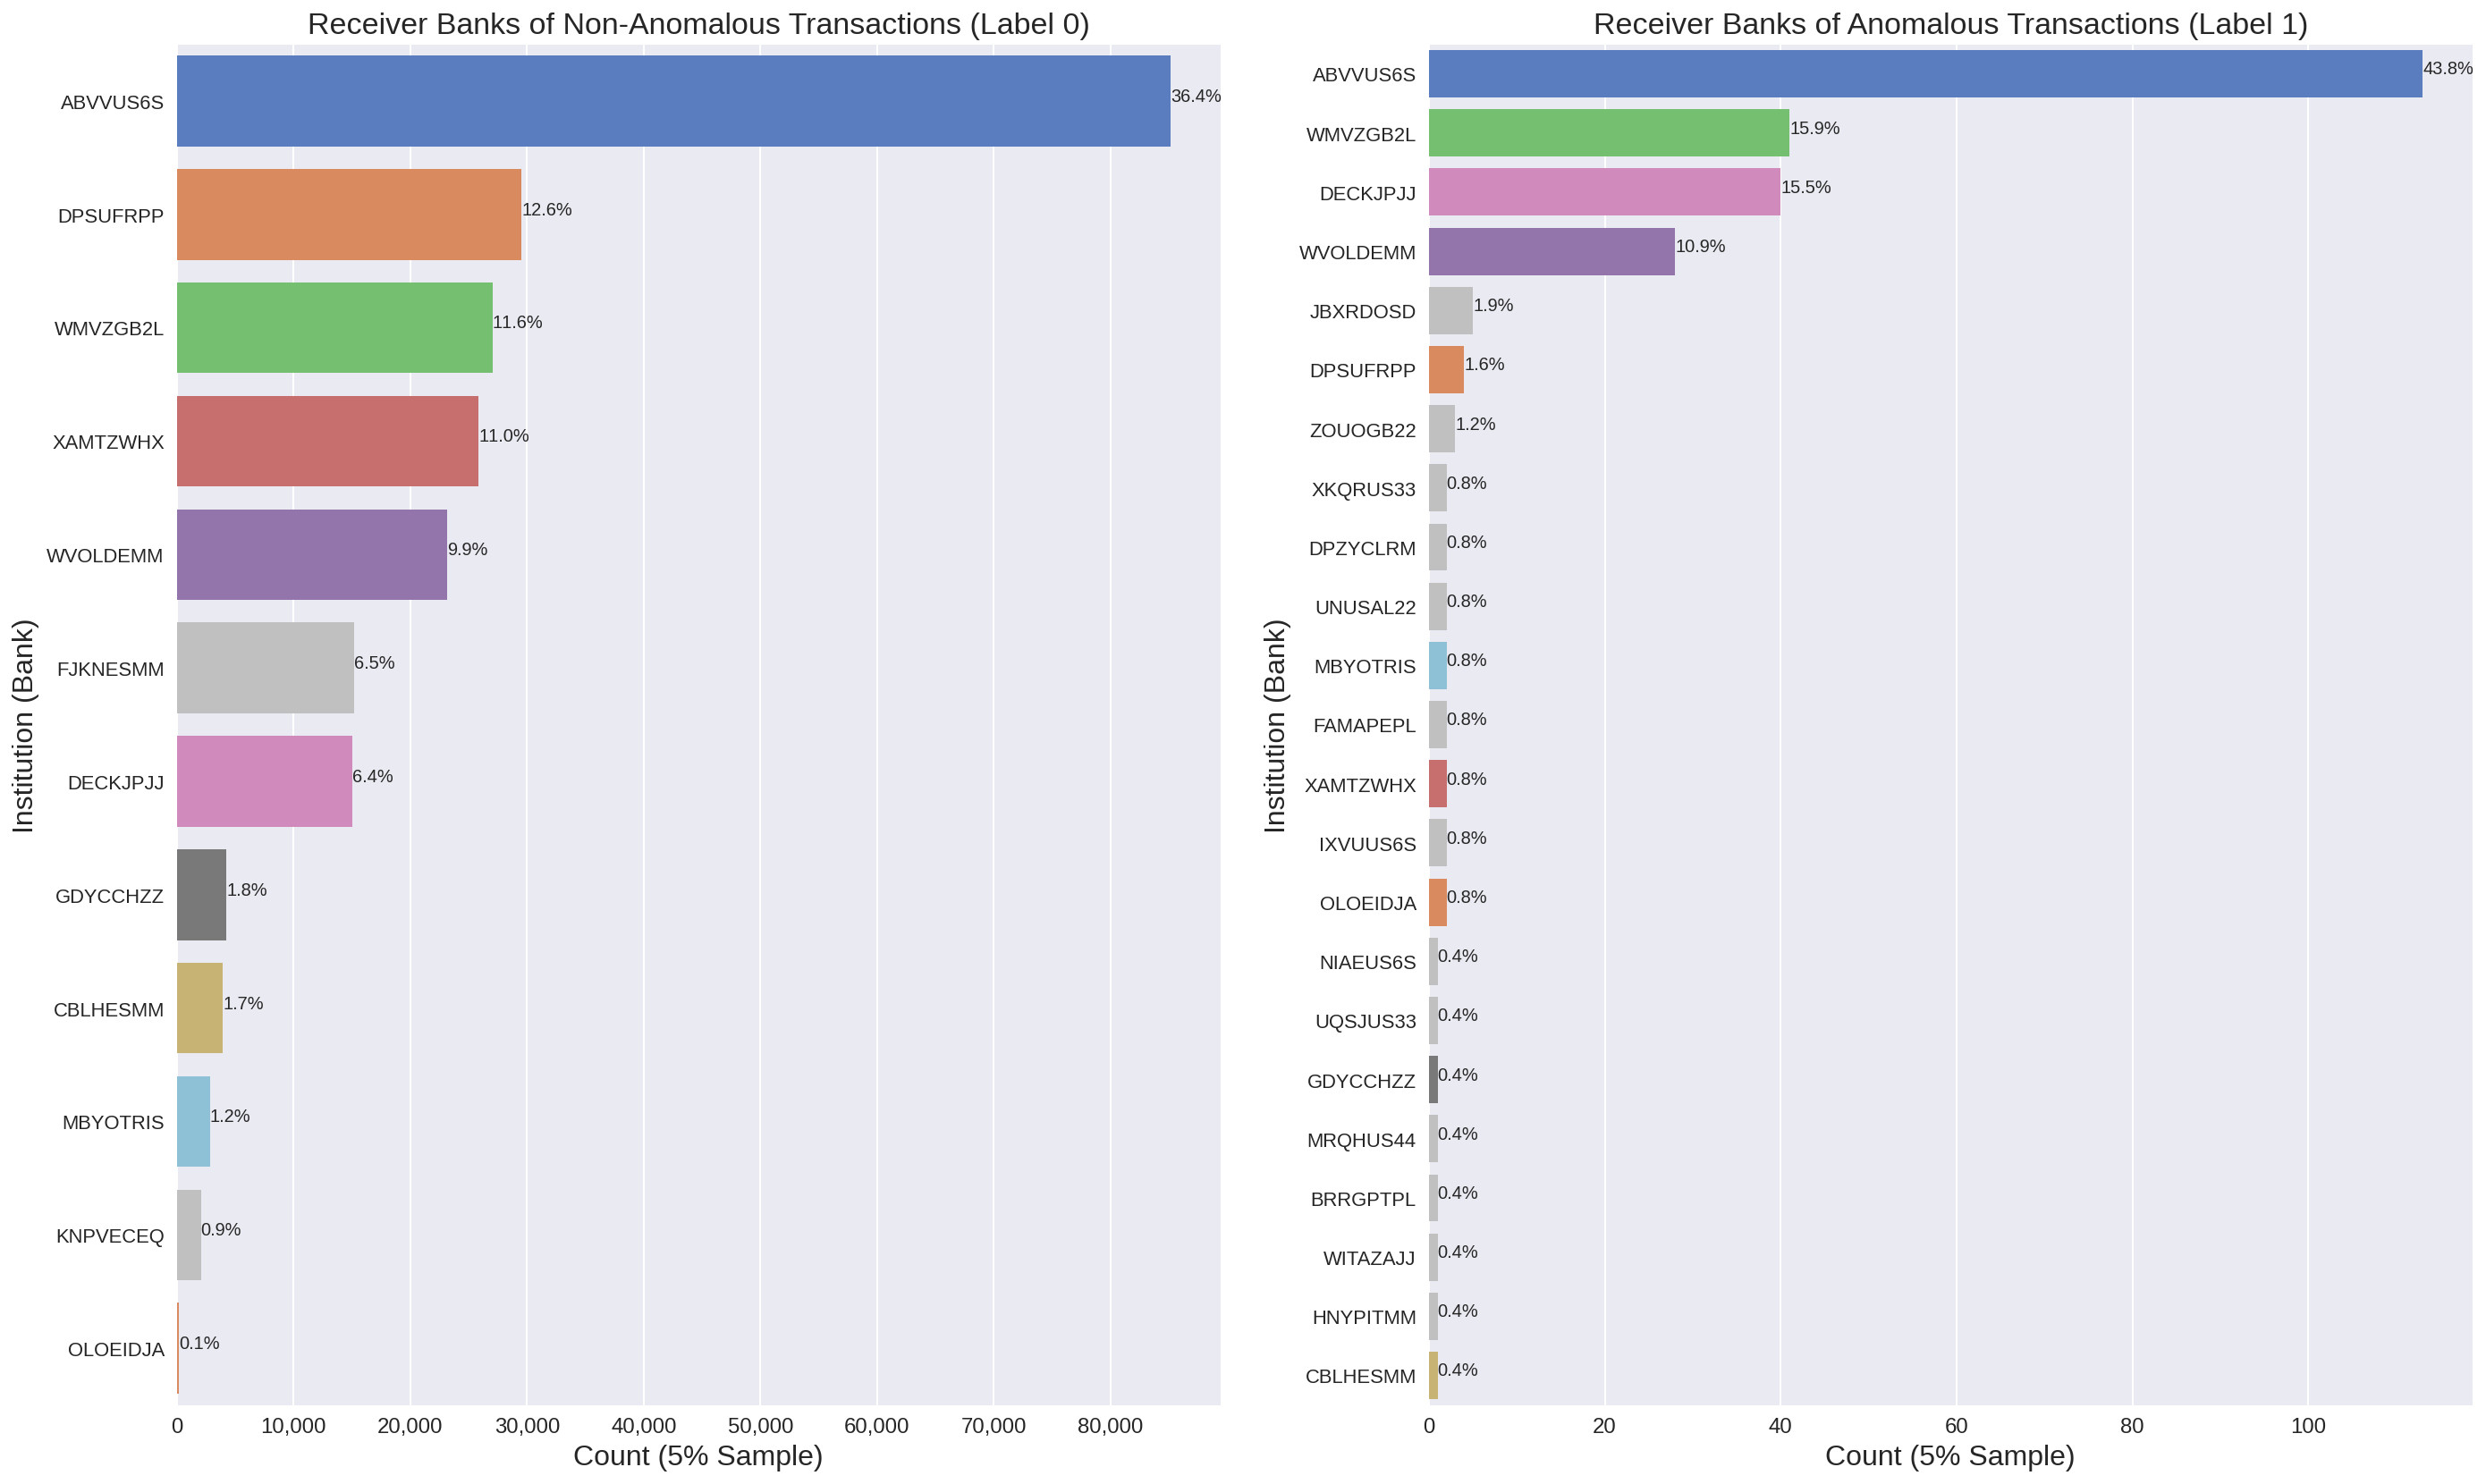

In [36]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(23, 14))

# Set consistent color palette where y-axis values in both axes, otherwise silver
palette = sns.color_palette('muted', as_cmap=True)*3
palette_map = {}
for val, color in zip(viz_df['Receiver'].value_counts().index, palette):
    if val in viz_df[viz_df.Label == 0]['Receiver'].value_counts().index \
    and val in viz_df[viz_df.Label == 1]['Receiver'].value_counts().index:
        palette_map[val] = color
    else:
        palette_map[val]= 'silver'

# Plot countplot of non-anomalous transactions
ax1_plot = sns.countplot(y='Receiver', data=viz_df[viz_df.Label == 0], ax=ax1, palette=palette_map, 
              order=viz_df[viz_df.Label == 0]['Receiver'].value_counts().index)  # Order descending

# Update palette_map with values not found above
for val, color in zip(viz_df[viz_df.Label == 1]['Receiver'].value_counts().index, palette):
    if val not in palette_map:
        palette_map[val] = 'silver'  # Assign values not found above to silver


# Plot countplot of anomalous transactions
ax2_plot = sns.countplot(y='Receiver', data=viz_df[viz_df.Label == 1], ax=ax2, palette=palette_map, 
              order=viz_df[viz_df.Label == 1]['Receiver'].value_counts().index)  # Order descending

# Print percentages to the right of bars (ax1)
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 0].shape[0])
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    ax1.annotate(percentage, (x, y))

# Print percentages to the right of bars (ax2)
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 1].shape[0])
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    ax2.annotate(percentage, (x, y))

ax1.set_title('Receiver Banks of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Count (5% Sample)', fontsize=16)
ax1.set_xticklabels(['{:,}'.format(int(x)) for x in ax1.get_xticks()], fontsize=12)
ax1.set_ylabel('Institution (Bank)', fontsize=16)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=11)
ax2.set_title('Receiver Banks of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Count (5% Sample)', fontsize=16)
ax2.set_xticklabels(ax2.get_xticks().astype(int), fontsize=12)
ax2.set_ylabel('Institution (Bank)', fontsize=16)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=11);

**Remarks:**
- It looks like the choice of sender bank is very informative in terms of determining whether a transaction is anomalous or not, while the choice of receiver bank is not nearly as valuable.
- Only 4 out of 16 sender banks tend to be utilized in anomalous transactions, while many more are utilized in non-anomalous transactions.
- Looking at receiver banks, 12 out of 16 tend to be utilized for non-anomalous transactions, while nearly all are utilized in anomalous transactions (though 4 are by far most common).
- It might be useful to engineer a feature or features in sender-receiver bank combinations, rather than just one or the other.

### Visualize target class distributions of instructed and settlement currencies used in transactions

In [37]:
# Display unique instructed currencies used in transactions
print(f"train_df, {train_df.select('InstructedCurrency').distinct().count()} unique instructed currencies:")
train_df.select('InstructedCurrency').distinct().show()

train_df, 8 unique instructed currencies:
+------------------+
|InstructedCurrency|
+------------------+
|               NZD|
|               GBP|
|               CAD|
|               EUR|
|               AUD|
|               JPY|
|               INR|
|               USD|
+------------------+



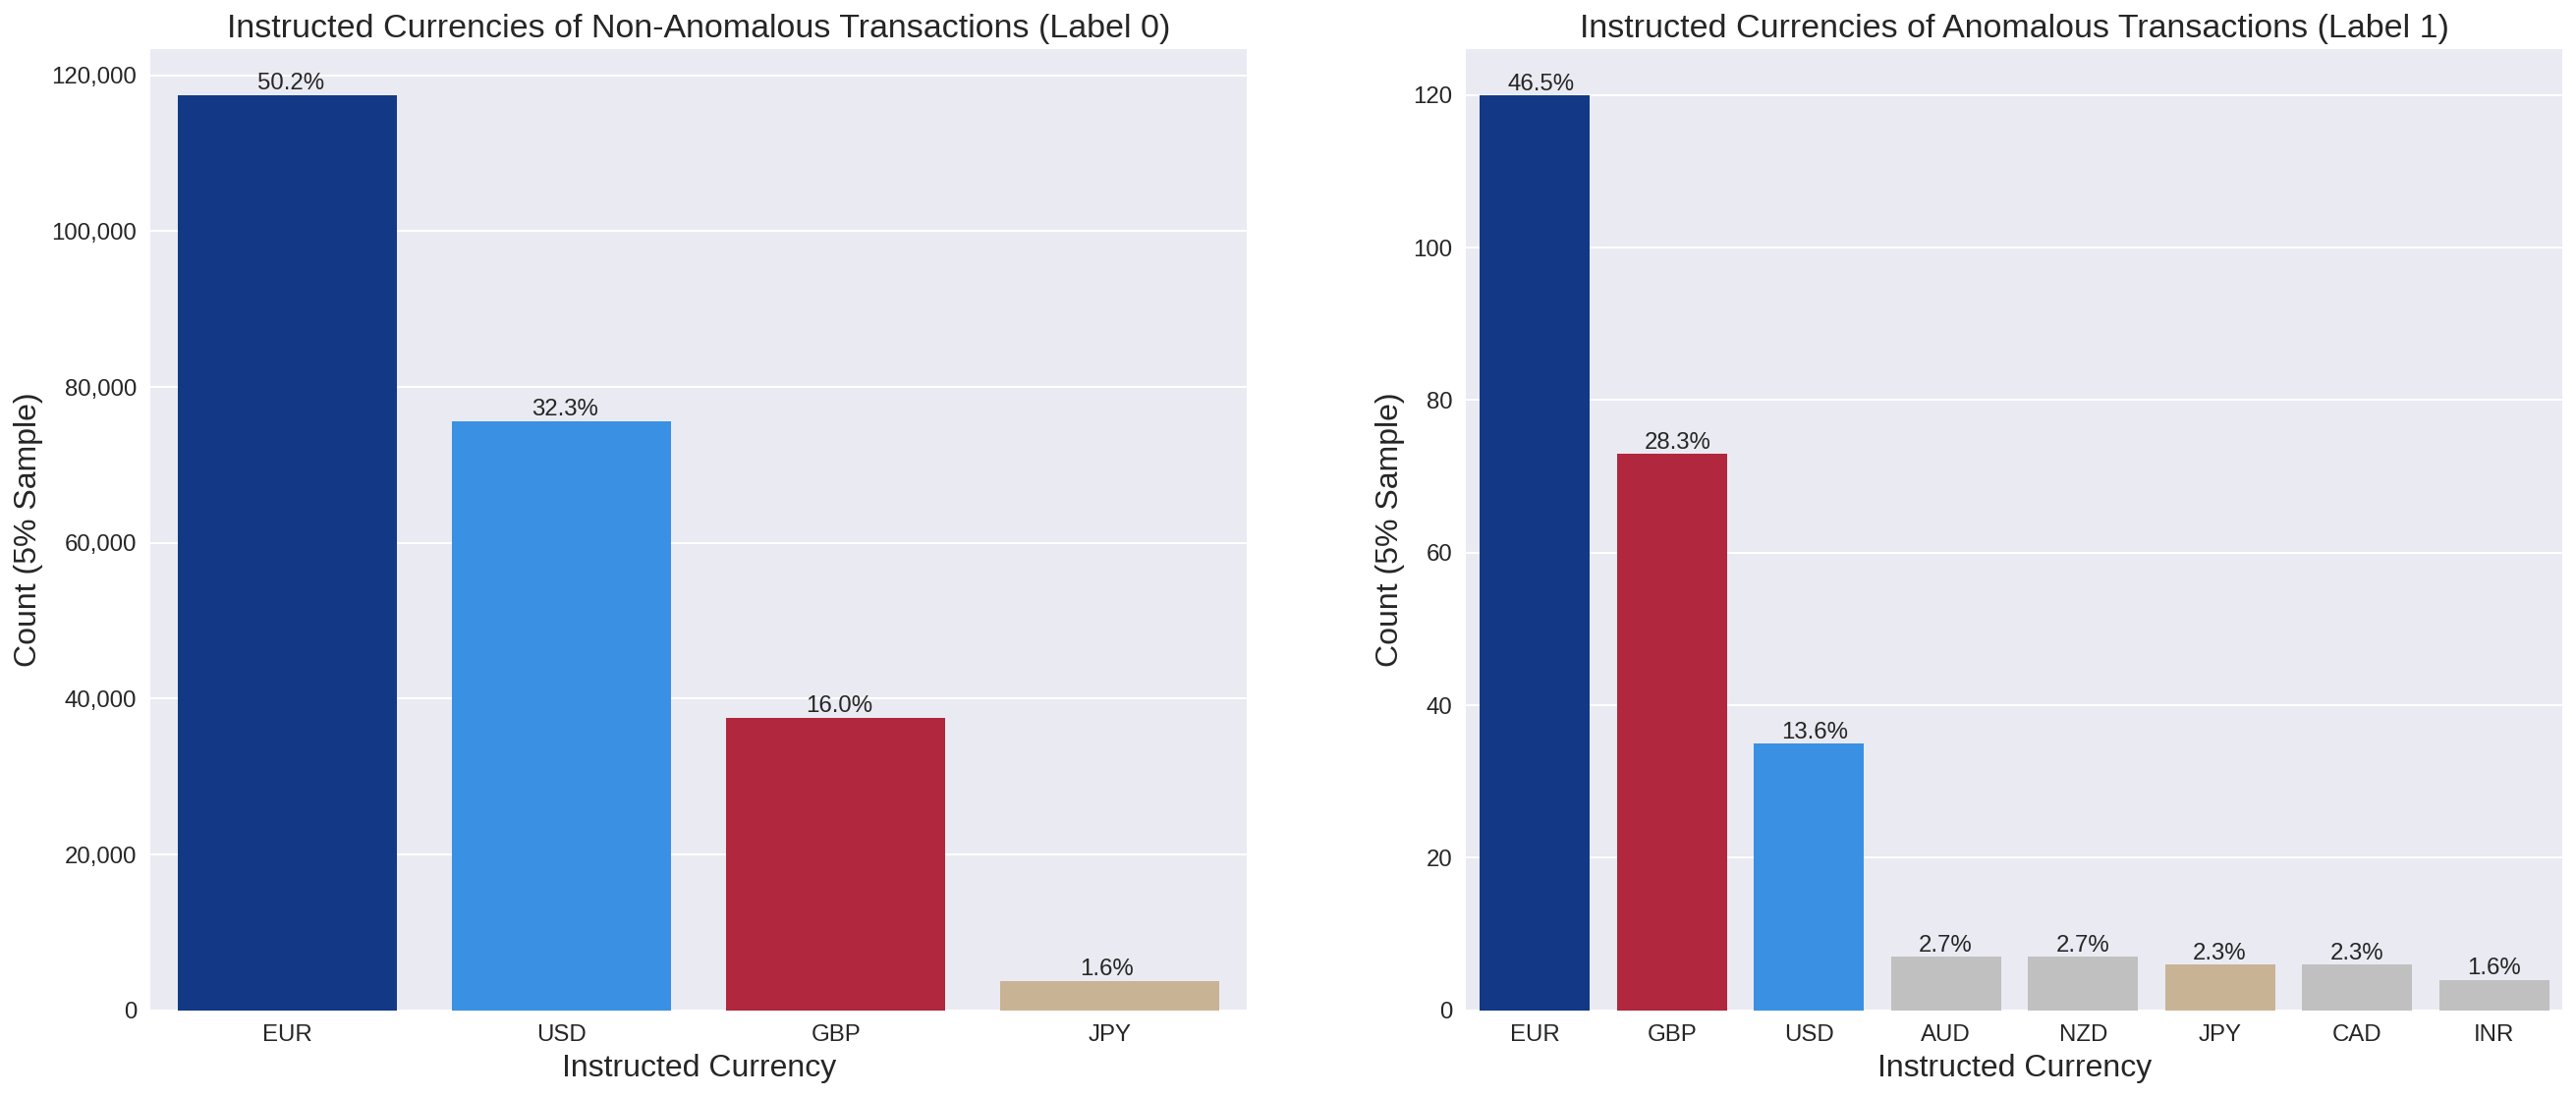

In [39]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 9))

# Set consistent color palette where x-axis values in both axes, otherwise silver
palette_map = {'USD': 'dodgerblue', 'EUR': '#003399', 'GBP':'#C8102E', 'JPY': 'tan'}
for val in viz_df[viz_df.Label == 1]['InstructedCurrency'].value_counts().index:
    if val not in viz_df[viz_df.Label == 0]['InstructedCurrency'].value_counts().index:
        palette_map[val] = 'silver'

# Plot countplot of non-anomalous transactions
sns.countplot(x='InstructedCurrency', data=viz_df[viz_df.Label == 0], ax=ax1, 
              order=viz_df[viz_df.Label == 0]['InstructedCurrency'].value_counts().index,  # Order descending
              palette=palette_map)

# Plot countplot of anomalous transactions
sns.countplot(x='InstructedCurrency', data=viz_df[viz_df.Label == 1], ax=ax2, 
              order=viz_df[viz_df.Label == 1]['InstructedCurrency'].value_counts().index,  # Order descending
              palette=palette_map)

# Print percentages on top of bars (ax1)
for p in ax1.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 0].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.29
    txt_y = p.get_height()+800
    ax1.text(txt_x, txt_y, txt, fontsize=12)

# Print percentages on top of bars (ax2)
for p in ax2.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 1].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.2
    txt_y = p.get_height()+0.7
    ax2.text(txt_x, txt_y, txt, fontsize=12)

ax1.set_title('Instructed Currencies of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Instructed Currency', fontsize=16)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_ylabel('Count (5% Sample)', fontsize=16)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks()], fontsize=12)
ax2.set_title('Instructed Currencies of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Instructed Currency', fontsize=16)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=12)
ax2.set_ylabel('Count (5% Sample)', fontsize=16)
ax2.set_yticklabels(ax2.get_yticks().astype(int), fontsize=12);

In [40]:
# Display unique settlement currencies used in transactions
print(f"train_df, {train_df.select('SettlementCurrency').distinct().count()} unique settlement currencies:")
train_df.select('SettlementCurrency').distinct().show()

train_df, 4 unique settlement currencies:
+------------------+
|SettlementCurrency|
+------------------+
|               GBP|
|               EUR|
|               JPY|
|               USD|
+------------------+



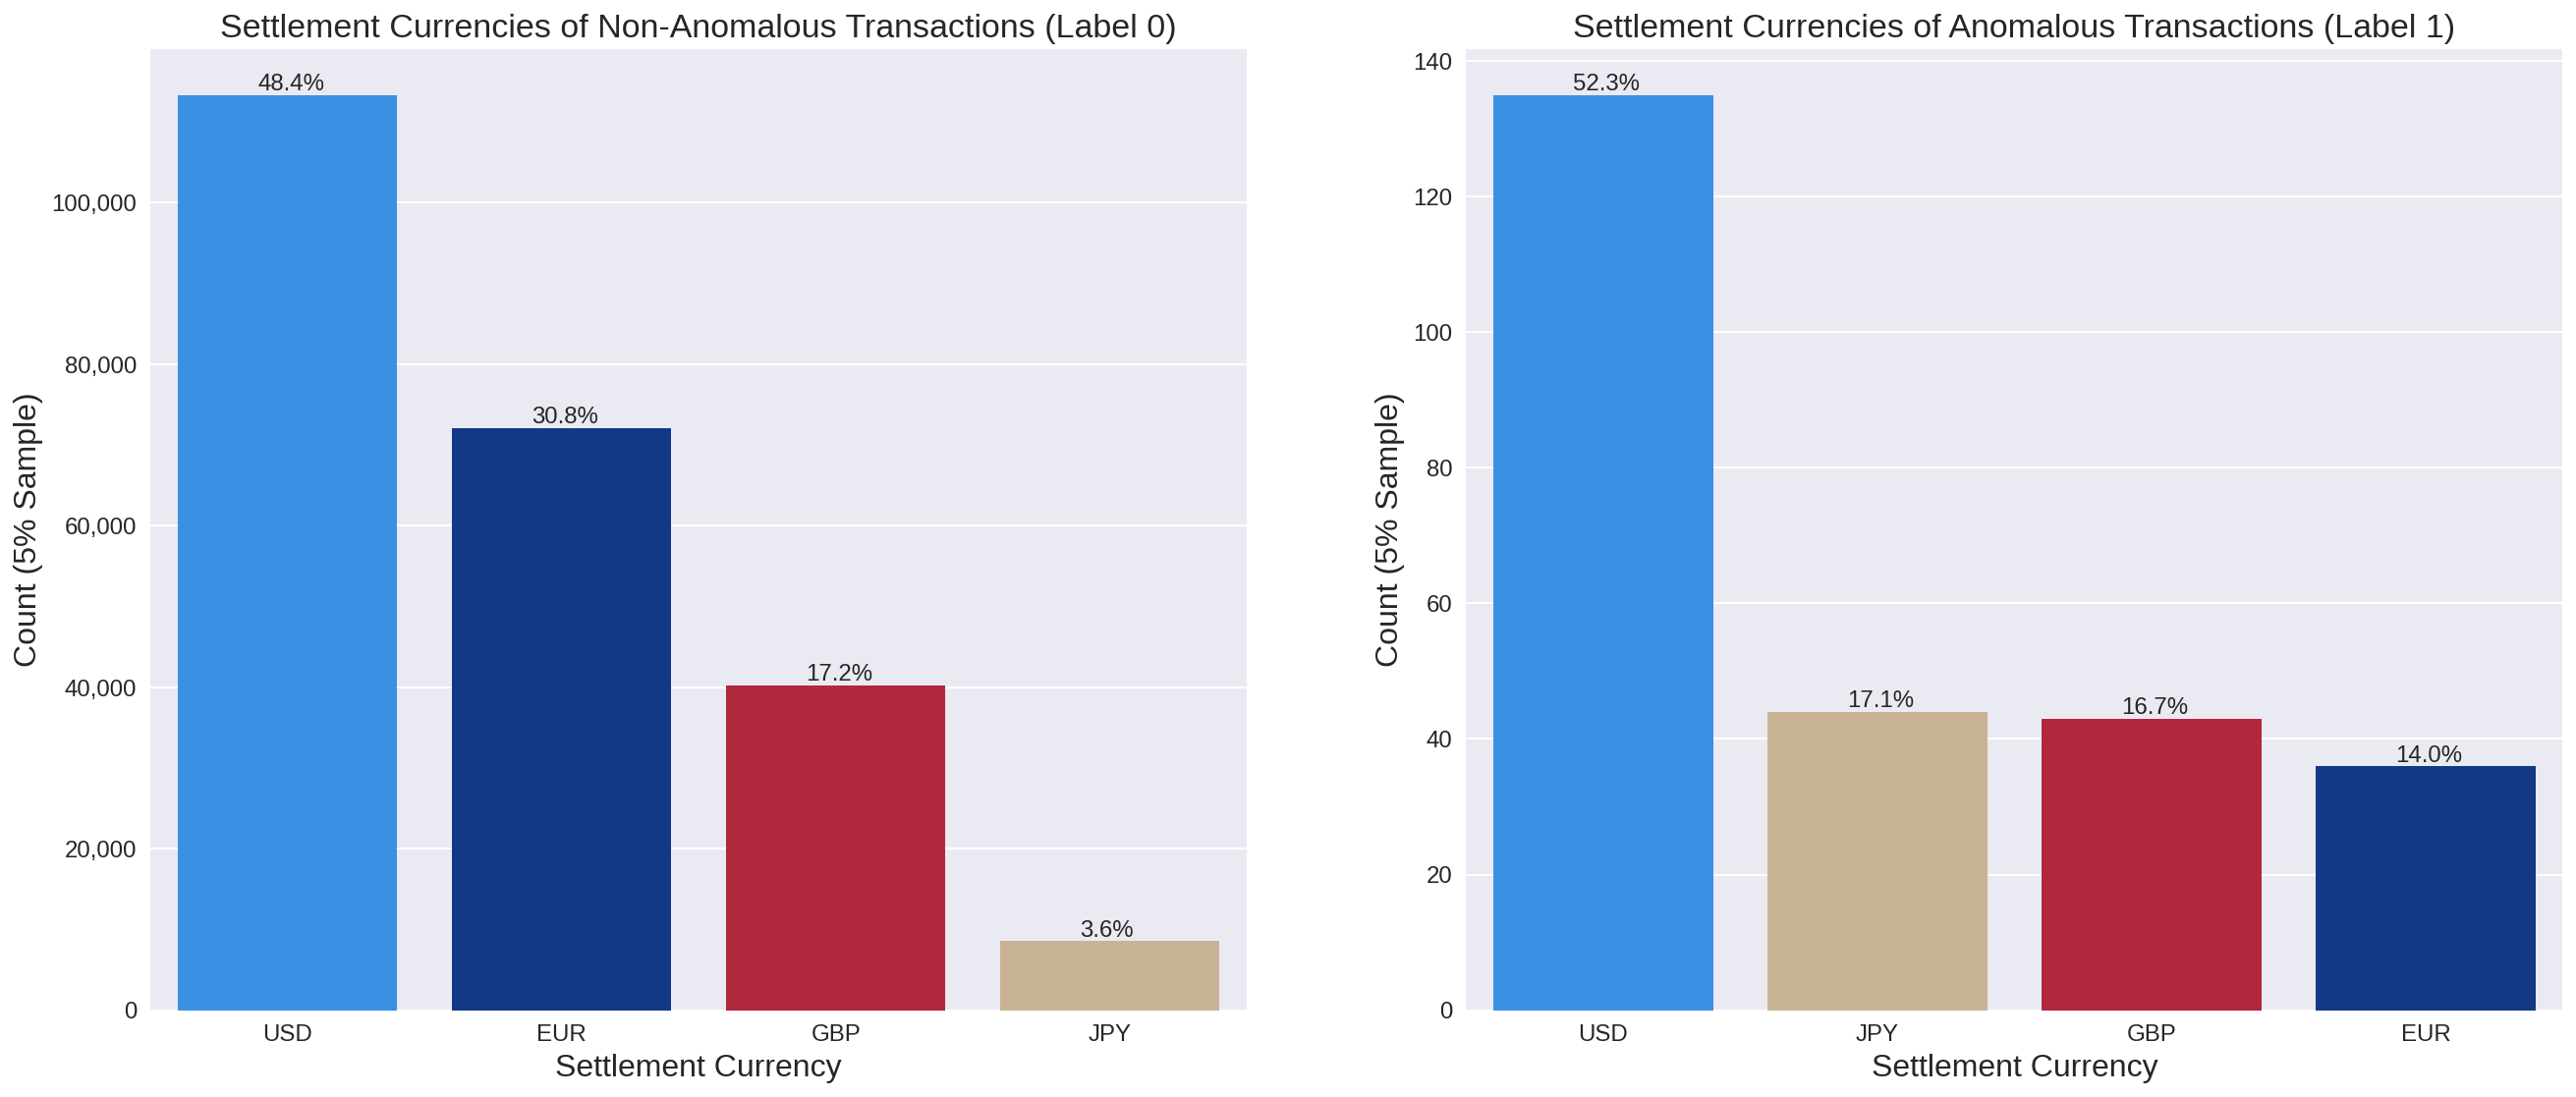

In [41]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 9))

# Set consistent color palette
palette_map = {'USD': 'dodgerblue', 'EUR': '#003399', 'GBP':'#C8102E', 'JPY': 'tan'}

# Plot countplot of non-anomalous transactions
sns.countplot(x='SettlementCurrency', data=viz_df[viz_df.Label == 0], ax=ax1, 
              order=viz_df[viz_df.Label == 0]['SettlementCurrency'].value_counts().index, # Order descending
              palette=palette_map)

# Plot countplot of anomalous transactions
sns.countplot(x='SettlementCurrency', data=viz_df[viz_df.Label == 1], ax=ax2, 
              order=viz_df[viz_df.Label == 1]['SettlementCurrency'].value_counts().index, # Order descending
              palette=palette_map)

# Print percentages on top of bars (ax1)
for p in ax1.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 0].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.29
    txt_y = p.get_height()+600
    ax1.text(txt_x, txt_y, txt, fontsize=12)

# Print percentages on top of bars (ax2)
for p in ax2.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 1].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.29
    txt_y = p.get_height()+0.7
    ax2.text(txt_x, txt_y, txt, fontsize=12)

ax1.set_title('Settlement Currencies of Non-Anomalous Transactions (Label 0)', fontsize=17)
ax1.set_xlabel('Settlement Currency', fontsize=16)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_ylabel('Count (5% Sample)', fontsize=16)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks()], fontsize=12)
ax2.set_title('Settlement Currencies of Anomalous Transactions (Label 1)', fontsize=17)
ax2.set_xlabel('Settlement Currency', fontsize=16)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=12)
ax2.set_ylabel('Count (5% Sample)', fontsize=16)
ax2.set_yticklabels(ax2.get_yticks().astype(int), fontsize=12);

**Remarks:**
- Instructed currencies seems to be more informative in terms of being correlated with whether or not a transaction is anomalous.
- Among instructed currencies, we see the opposite trend as we saw with chosen banks; anomalous transactions tend to use a broader selection of instructed currencies, rather than a more narrow selection as we saw with chosen sender banks.
- Among settlement currencies, we see the same four currencies being utilized among both target classes, but in slightly different frequencies.